In [5]:
import eko
import pineappl 
import numpy as np
import yaml
import pdffit
from pdffit.examples import parametrizations as pars
import torch
from matplotlib import pyplot as plt

plt.rcParams.update({
    #"figure.dpi": 100,               
    #"savefig.dpi": 100,             
    "figure.figsize": (10, 6),
    'text.usetex': True,
    "font.family": 'Computer Modern',  
    "font.size": 15     
})

device = pdffit.device

In [6]:
def sort_rm(channels):
	ev_pid = np.array(eko.basis_rotation.evol_basis_pids)
	idx = np.zeros(np.shape(channels)[0], dtype=np.int32)
	for i, item in enumerate(channels):
		idx[i] = np.sum(np.where(ev_pid == item[0], np.arange(0, np.shape(ev_pid)[0]), 0))
	return eko.basis_rotation.rotate_flavor_to_evolution[idx]

def beta_pdf(x, b):
    return torch.exp(b.log_prob(x))

def to_sigmared(fk, rotpdf):
	return (fk[:,:,:,0] * rotpdf).sum((1,2))

In [7]:
with open("/afs/ipp-garching.mpg.de/home/h/hildebra/MA/data/evo/sigmareds/HERA_NC_318GEV_data_EM-SIGMARED_153.yaml", 'r') as f:
	sigmared = torch.tensor(yaml.safe_load(f)["data_central"], device=device).detach()

In [8]:
fk = pineappl.fk_table.FkTable.read("/afs/ipp-garching.mpg.de/home/h/hildebra/MA/data/evo/fktables/HERA_NC_318GEV_EM_SIGMARED_153.pineappl.lz4")
fkm = torch.tensor(fk.table(), device=device, dtype=torch.float32).detach()
#fk._raw.table().shape
#fk._raw.channels()

In [52]:
fkm.shape

torch.Size([159, 12, 35, 1])

In [9]:
srm = torch.tensor(sort_rm(fk._raw.channels()), device=device, dtype=torch.float32)
srm

tensor([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  1., -1.,  0., -1.,  1.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0., -2.,  1.,  1.,  0.,  1.,  1., -2.,  0.,  0.,  0.],
        [ 0.,  0.,  0., -3.,  1.,  1.,  1.,  0.,  1.,  1.,  1., -3.,  0.,  0.],
        [ 0.,  0., -4.,  1.,  1.,  1.,  1.,  0.,  1.,  1.,  1.,  1., -4.,  0.],
        [ 0.,  1.,  1.,  1.,  1.,  1.,  1.,  0.,  1.,  1.,  1.,  1.,  1.,  1.],
        [ 0.,  0.,  0.,  0.,  0., -1.,  1.,  0., -1.,  1.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  2., -1., -1.,  0.,  1.,  1., -2.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  3., -1., -1., -1.,  0.,  1.,  1.,  1., -3.,  0.,  0.],
        [ 0.,  0.,  4., -1., -1., -1., -1.,  0.,  1.,  1.,  1.,  1., -4.,  0.],
        [ 0., -1., -1., -1., -1., -1., -1.,  0.,  1.,  1.,  1.,  1.,  1.,  1.]],
       device='cuda:0')

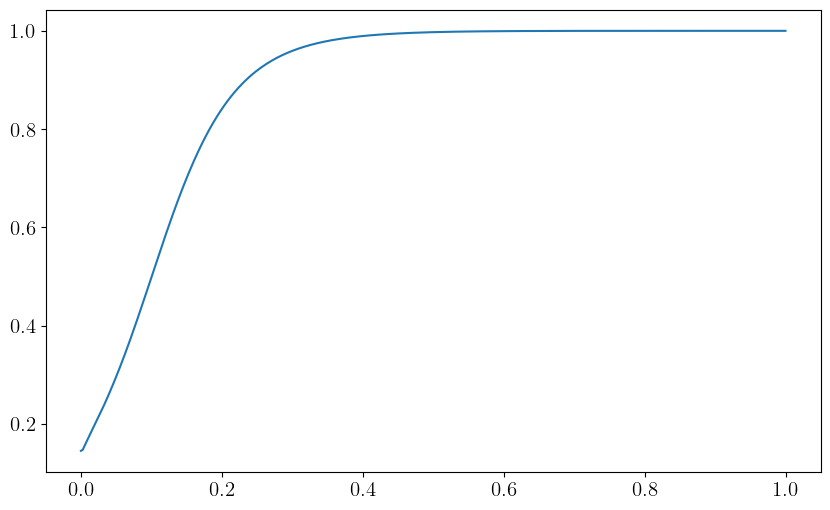

In [57]:
pdffit.plot_trafo(ub_net)

In [ ]:
beta_uv = torch.distributions.Beta(torch.tensor(2.0, device=device), torch.tensor(7.0, device=device))
beta_ub = torch.distributions.Beta(torch.tensor(0.8, device=device), torch.tensor(5.0, device=device))
beta_dv = torch.distributions.Beta(torch.tensor(2.0, device=device), torch.tensor(7.0, device=device))
beta_db = torch.distributions.Beta(torch.tensor(0.8, device=device), torch.tensor(5.0, device=device))
beta_g  = torch.distributions.Beta(torch.tensor(0.8, device=device), torch.tensor(5.0, device=device))


delta_uv   = 0.3
delta_dv   = 0.15
delta_dsea = 0.05
delta_usea = 0.075
delta_g    = 0.3

In [20]:
xgrid = torch.tensor(fk._raw.x_grid(), device=device, dtype=torch.float32).view(-1,1).detach()

In [27]:
hidden_dim=64
in_out_dim=1

uv_net 	   = pdffit.nn.DFF_f(in_out_dim, hidden_dim, trafo="sig", w_init_=True).to(device)
ub_net 	   = pdffit.nn.DFF_f(in_out_dim, hidden_dim, trafo="sig", w_init_=True).to(device)
dv_net 	   = pdffit.nn.DFF_f(in_out_dim, hidden_dim, trafo="sig", w_init_=True).to(device)
db_net 	   = pdffit.nn.DFF_f(in_out_dim, hidden_dim, trafo="sig", w_init_=True).to(device)
g_net  	   = pdffit.nn.DFF_f(in_out_dim, hidden_dim, trafo="sig", w_init_=True).to(device) 

uv_inv_net = pdffit.nn.DFF_g(in_out_dim, hidden_dim, trafo="sig").to(device)
ub_inv_net = pdffit.nn.DFF_g(in_out_dim, hidden_dim, trafo="sig").to(device)
dv_inv_net = pdffit.nn.DFF_g(in_out_dim, hidden_dim, trafo="sig").to(device)
db_inv_net = pdffit.nn.DFF_g(in_out_dim, hidden_dim, trafo="sig").to(device)
g_inv_net  = pdffit.nn.DFF_g(in_out_dim, hidden_dim, trafo="sig").to(device) 

params = list(uv_net.parameters()) + list(ub_net.parameters()) + list(dv_net.parameters()) + list(db_net.parameters()) + list(g_net.parameters()) + list(
          uv_inv_net.parameters()) + list(ub_inv_net.parameters()) + list(dv_inv_net.parameters()) + list(db_inv_net.parameters()) + list(g_inv_net.parameters())

In [33]:
opt = torch.optim.NAdam(params, lr=1e-4)
mse = torch.nn.MSELoss()

In [44]:
debug_ = 0

for itr in range(50000):
	opt.zero_grad()

	uv_flown = pdffit.nn.flown(xgrid, uv_net, beta_uv).exp()
	ub_flown = pdffit.nn.flown(xgrid, ub_net, beta_ub).exp()
	dv_flown = pdffit.nn.flown(xgrid, dv_net, beta_dv).exp()
	db_flown = pdffit.nn.flown(xgrid, db_net, beta_db).exp()
	g_flown  = pdffit.nn.flown(xgrid, g_net , beta_g ).exp()

	pdf_m = torch.zeros((14, uv_flown.shape[0]), device=device, dtype=torch.float32)

	pdf_m[9] = delta_uv  *uv_flown.view(-1) + delta_usea*ub_flown.view(-1)
	pdf_m[5] = delta_usea*ub_flown.view(-1)
	pdf_m[7] = delta_g   *g_flown.view(-1)
	pdf_m[8] = delta_dv  *dv_flown.view(-1) + delta_dsea*db_flown.view(-1)
	pdf_m[6] = delta_dsea*db_flown.view(-1)

	rot_pdf = torch.matmul(srm.detach(), pdf_m/xgrid.view(1,-1))

	loss = mse(to_sigmared(fkm.detach(), rot_pdf), sigmared.detach())
	loss.backward()
	opt.step()

	if itr % 250 == 0:
		# debug = to_sigmared(fkm, rot_pdf)
		# debug_ = uv_net(xgrid)
		print(itr, " ", loss.item())

0   0.0003461726300884038
250   0.00034604890970513225
500   0.0003458552819211036
750   0.0003455366531852633
1000   0.0003456239646766335
1250   0.00034520585904829204
1500   0.00034524142392911017
1750   0.0003450450021773577
2000   0.00034480588510632515
2250   0.000344633444910869
2500   0.00034433879773132503
2750   0.00034400809090584517
3000   0.00034349082852713764
3250   0.00034307377063669264
3500   0.0003422674199100584
3750   0.0003414659877307713
4000   0.0003401030844543129
4250   0.0003382657596375793
4500   0.0003360050613991916
4750   0.00033377771615050733
5000   0.0003317406808491796
5250   0.0003300394455436617
5500   0.00032898609060794115
5750   0.00032794487196952105
6000   0.00032712507527321577
6250   0.00032665784237906337
6500   0.00032601357088424265
6750   0.0003257422358728945
7000   0.0003252742753829807
7250   0.000325046363286674
7500   0.0003247783752158284
7750   0.00032445351826027036
8000   0.00032437389018014073
8250   0.0003241418453399092
8500  

ValueError: Expected value argument (Tensor of shape (35, 1)) to be within the support (Interval(lower_bound=0.0, upper_bound=1.0)) of the distribution Beta(), but found invalid values:
tensor([[nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan]], device='cuda:0', grad_fn=<SigmoidBackward0>)

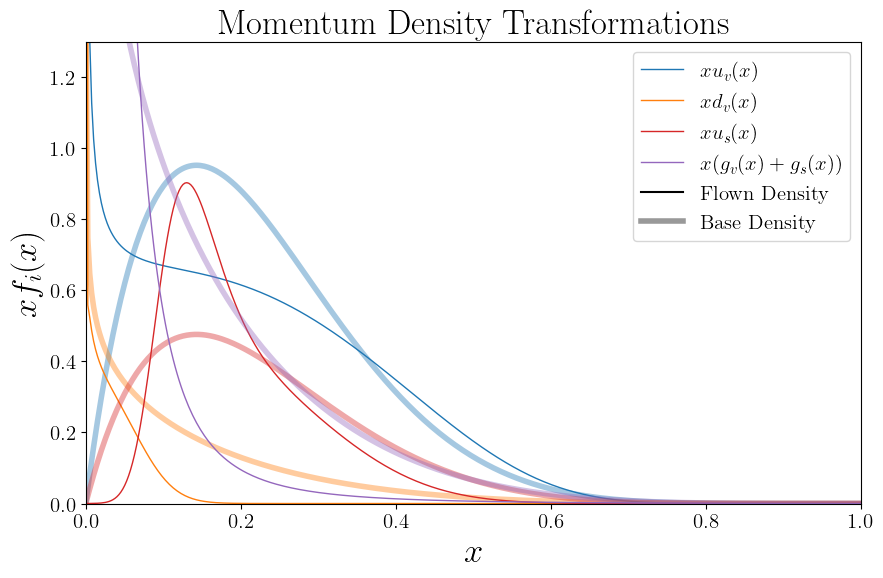

In [ ]:
plt.ylim(0, 1.3)
plt.xlim(0, 1)
bounds = (1e-4, 1-1e-4)

pdffit.plot_densities(uv_net, uv_inv_net, beta_uv, beta_uv, tb_disp=(False, True), fi_disp=(True, False), fac=delta_uv  , bounds = bounds, fcolor="C0", bcolor="C0", balpha=0.4, blabel=None, flabel=r'$x u_v(x)$'         )
pdffit.plot_densities(ub_net, ub_inv_net, beta_ub, beta_ub, tb_disp=(False, True), fi_disp=(True, False), fac=delta_usea, bounds = bounds, fcolor="C1", bcolor="C1", balpha=0.4, blabel=None, flabel=r'$x d_v(x)$'         )
pdffit.plot_densities(dv_net, dv_inv_net, beta_dv, beta_dv, tb_disp=(False, True), fi_disp=(True, False), fac=delta_dv  , bounds = bounds, fcolor="C3", bcolor="C3", balpha=0.4, blabel=None, flabel=r'$x u_s(x)$'         )
pdffit.plot_densities(db_net, db_inv_net, beta_db, beta_db, tb_disp=(False, True), fi_disp=(True, False), fac=delta_dsea, bounds = bounds, fcolor="C2", bcolor="C2", balpha=0.4, blabel=None, flabel=r'$x d_s(x)$'         )
pdffit.plot_densities(g_net , g_inv_net , beta_g , beta_g , tb_disp=(False, True), fi_disp=(True, False), fac=delta_g   , bounds = bounds, fcolor="C4", bcolor="C4", balpha=0.4, blabel=None, flabel=r'$x (g_v(x)+g_s(x))$')

plt.plot(0,0, "k", label="Flown Density")
#plt.plot(0,0, "k", ls="--", alpha=0.4, label="Mean Adjusted")
plt.plot(0,0, "k", lw=4, alpha=0.4, label="Base Density")

plt.title("Momentum Density Transformations", fontsize=25)
plt.ylabel(r"$x f_i(x)$", fontsize=25)
plt.xlabel(r"$x$", fontsize=25)
plt.legend(fontsize=15)
#plt.hist(gluons(p_z1_x_g1, p_z1_x_g2).sample((1,500000))[0].cpu().numpy(),density=True, range=(0.0000001,1), bins=500)
#plt.yscale('log')
#plt.savefig("flow_pmd.pdf", bbox_inches='tight')

In [ ]:
import importlib
importlib.reload(pdffit.viz.plot_utils)
importlib.reload(pdffit.nn)
importlib.reload(pdffit)

<module 'pdffit' from '/home/iwsatlas1/hildebra/MA/MA/lib/python3.13/site-packages/pdffit/__init__.py'>